In [1]:
using LazySets, Plots

In [2]:
X = HPolytope([HalfSpace([1.0, 1.0, 0.0], 4.0),
               HalfSpace([-1.0, -1.0, -0.0], -4.0),
               HalfSpace([-1.0, 0.0, 0.0], -0.0),
               HalfSpace([0.0, -1.0, 0.0], -0.0),
               HalfSpace([0.0, 0.0, -1.0], -0.0),
               HalfSpace([1.0, 0.0, 0.0], 10.0),
               HalfSpace([0.0, 1.0, 0.0], 10.0),
               HalfSpace([0.0, 0.0, 1.0], 10.0),
               HalfSpace([0.0, 1.0, 1.0], 6.0)])

HPolytope{Float64,Array{Float64,1}}(HalfSpace{Float64,Array{Float64,1}}[HalfSpace{Float64,Array{Float64,1}}([1.0, 1.0, 0.0], 4.0), HalfSpace{Float64,Array{Float64,1}}([-1.0, -1.0, -0.0], -4.0), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0, 0.0], -0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0, 0.0], -0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, -1.0], -0.0), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0, 0.0], 10.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 1.0, 0.0], 10.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 0.0, 1.0], 10.0), HalfSpace{Float64,Array{Float64,1}}([0.0, 1.0, 1.0], 6.0)])

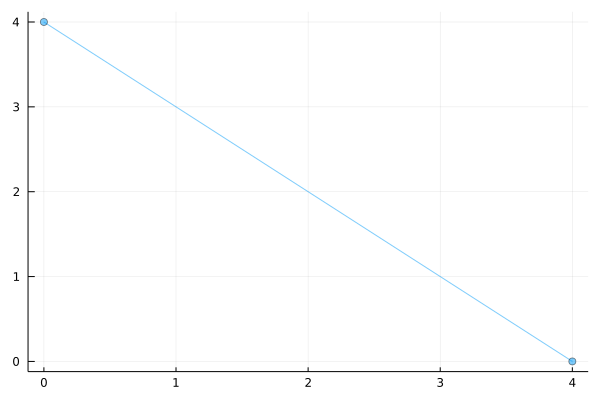

In [3]:
plot(Projection(X, [1, 2]), 1e-2)

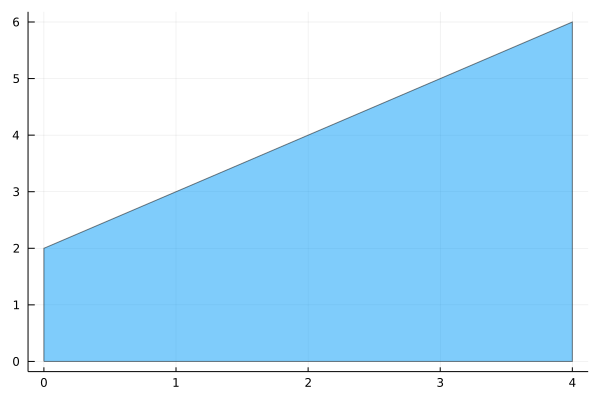

In [4]:
plot(Projection(X, [1, 3]), 1e-2)

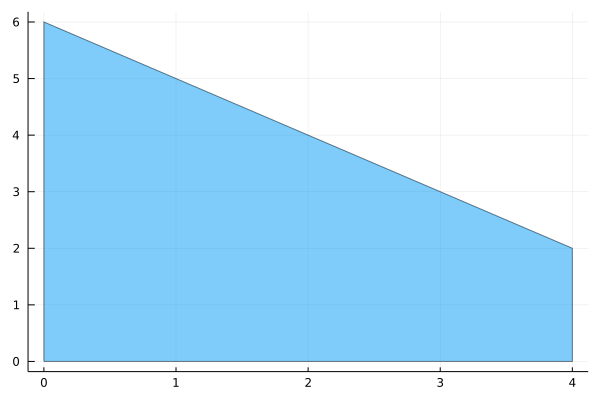

In [5]:
plot(Projection(X, [2, 3]), 1e-2)

The method used by default is rejection sampling, see the wikipedia article https://en.wikipedia.org/wiki/Rejection_sampling

Rejection sampling from a flat set may take a very long time.

In [6]:
[@time sample(X) for _ in 1:5]

  2.570704 seconds (17.20 M allocations: 1.734 GiB, 9.44% gc time)
  2.281921 seconds (17.57 M allocations: 1.832 GiB, 9.65% gc time)
  5.901703 seconds (44.77 M allocations: 4.670 GiB, 9.22% gc time)
  3.809821 seconds (29.13 M allocations: 3.038 GiB, 9.18% gc time)
 13.705801 seconds (103.61 M allocations: 10.807 GiB, 9.12% gc time)


5-element Array{Array{Float64,1},1}:
 [3.279770262326519, 0.7202297604164256, 3.632261457527195]
 [2.3270698102921132, 1.6729302153500463, 1.303454825677116]
 [3.722018077745896, 0.27798188552693226, 4.299376160717442]
 [3.3729037853389556, 0.6270962565502103, 2.5450307961790224]
 [3.104373067284868, 0.8956269026825758, 0.215814004873216]

In [7]:
[3.6703993599836338, 0.32960065398468164, 3.5095074587395745] ∈ X

true

## Particular solution 

One alternative for faster sampling here is to take the cartesian decomposition onto the plane 1-2 and on the plane 3 separately, take random samples, and then reconstruct the set with a cartesian product.

Let's create a new `_sample` function that receives the set to be sampled, the number of points to be sampled, a tolerance (for 2D approximations), and the vector `flat_vars` corresponding to the coordinates (or variables) in which the set is flat when projected onto those coordinates.

In [8]:
function _sample(X::LazySet, npoints=1; ε=1e-3, flat_vars=[1, 2])
    @assert dim(X) == 3
    @assert length(flat_vars) == 2

    # classify according to the number of vertices
    Xproj = Projection(X, flat_vars)
    Xproj = overapproximate(Xproj, ε)
    Vproj = vertices_list(Xproj)
    m = length(Vproj)

    if m > 2
        # general case, non-flat in flat_vars,
        # may take a long time if the set is flat in other coordinates
        out = sample(X, npoints)

    else
        out = _sample_flat(X, npoints, flat_vars, Vproj)
    end
    return out
end

function _sample_flat(X, npoints, flat_vars, Vproj)
    n = dim(X)
    
    # construct sample from non-flat projection
    nonflat_vars = setdiff(1:n, flat_vars)
    Xproj′ = Projection(X, nonflat_vars)
    Xproj′ = overapproximate(Xproj′, Interval)
    S′ = sample(Xproj′, npoints)

    # construct sample from flat projection
    m = length(Vproj)
    if m == 2
        L = LineSegment(Vproj[1], Vproj[2])
        S = sample(L, npoints)
    elseif m == 1
        S = Vproj
    end

    # reconstruct cartesian product; this part (vcat) has to be generalized
    # if the decomposition doesn't begin with flat_vars = [1, 2]
    @assert collect(flat_vars) == [1, 2]
    out = Vector{eltype(S)}()
    for i in 1:npoints
        for j in 1:npoints
            push!(out, vcat(S[i], S′[j]))
        end
    end

    # now we throw points which are not in the set; because cartesian decomposition
    # overapproximates in general
    idx = Vector{Int}()
    for i in 1:length(out)
        if out[i] ∈ X
            push!(idx, i)
        end
    end
    return out[idx]
end

_sample_flat (generic function with 1 method)

In [9]:
Xs = _sample(X, 10)

all(x -> x ∈ X, Xs)

true

In [10]:
@time Xs = _sample(X, 50);

  0.001384 seconds (3.59 k allocations: 473.828 KiB)


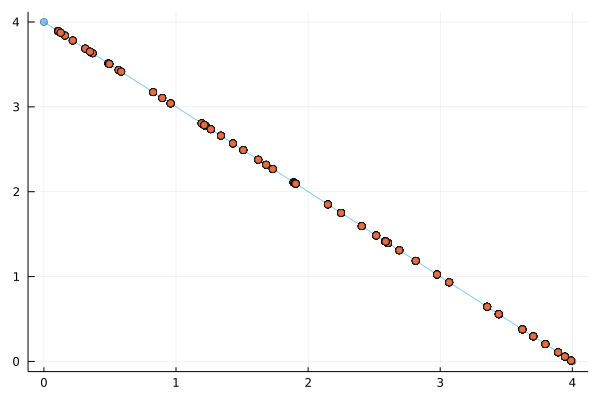

In [11]:
plot(Projection(X, [1, 2]))
plot!([Singleton(v[[1, 2]]) for v in Xs])

In [12]:
v[[1, 2]]

LoadError: UndefVarError: v not defined

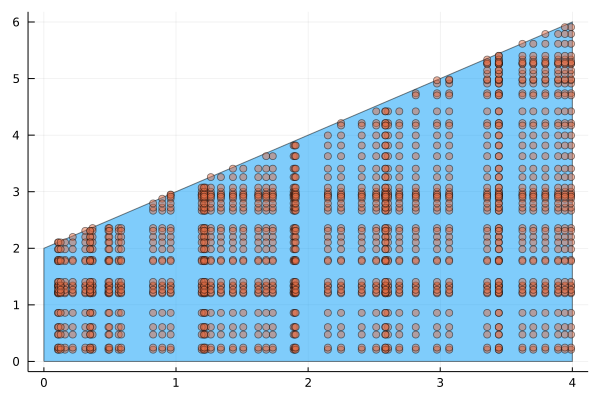

In [13]:
plot(Projection(X, [1, 3]))
plot!([Singleton(v[[1, 3]]) for v in Xs])

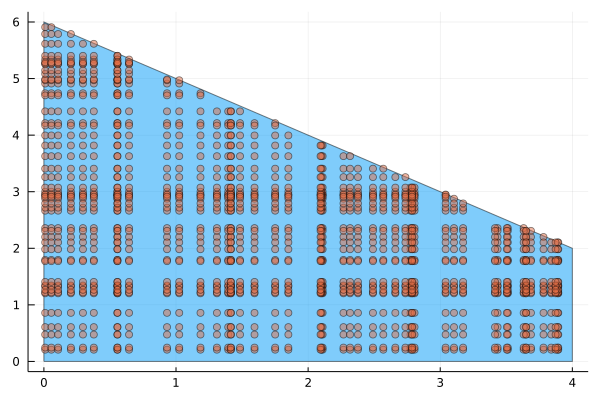

In [14]:
plot(Projection(X, [2, 3]))
plot!([Singleton(v[[2, 3]]) for v in Xs])